## Car model detector

## 1. Download images of cars

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [9]:
urls = search_images('BMW photos', max_images=1)
dest = 'bmw.jpg'
download_url(urls[0], dest, show_progress=False)

Searching for 'BMW photos'


Path('bmw.jpg')

Searching for 'mercedes car photos'


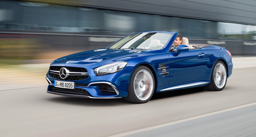

In [4]:
download_url(search_images('mercedes car photos', max_images=1)[0], 'mercedes.jpg', show_progress=False)
Image.open('mercedes.jpg').to_thumb(256,256)

#### Download images for training

In [10]:
searches = 'mercedes car','bmw car','ford car','yamaha motorcycle'
path = Path('datasets/images')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} in sun photo'))
    # sleep(10)
    download_images(dest, urls=search_images(f'{o} at night photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'mercedes car photo'
Searching for 'mercedes car in sun photo'
Searching for 'mercedes car at night photo'
Searching for 'bmw car photo'
Searching for 'bmw car in sun photo'
Searching for 'bmw car at night photo'
Searching for 'ford car photo'
Searching for 'ford car in sun photo'
Searching for 'ford car at night photo'
Searching for 'yamaha motorcycle photo'
Searching for 'yamaha motorcycle in sun photo'
Searching for 'yamaha motorcycle at night photo'


/home/kuph/fastai_course/venv/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## 2. Train a model

Remove invalid images

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

21

Load data

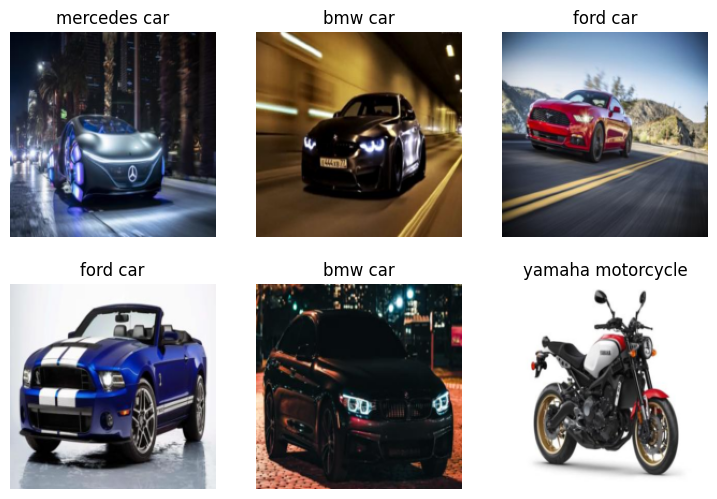

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Train resnet18 model

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/kuph/fastai_course/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kuph/fastai_course/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.859390,1.175626,0.420455,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.002064,0.948283,0.340909,00:16
1,0.626659,0.750251,0.215909,00:18
2,0.450407,0.741803,0.215909,00:17


In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

## 3. Use the model

In [15]:
is_bmw,_,probs = learn.predict(PILImage.create('bmw.jpg'))
print(f"This is a: {is_bmw}.")
print(f"Probability it's a bmw car: {probs[0]:.4f}")

This is a: bmw car.
Probability it's a bmw car: 0.9669
